Author : Yassine El Ouahidi, inspired by Myriam Bontonou

Using the IBC dataset, we can define a classification problem where a class is a condition studied during a fMRI task (e.g. *audio sentence*, *speech sound*, *face gender*, *reward*, *left hand*...). The data samples are elementary contrast maps associated with a condition studied during a task performed by a subject. 

Broadly speaking, an elementary contrast map is a 3D volume. Each voxel (elementary volume) represents the activation of an area of the brain with respect to the studied condition.

In this notebook, we prepare a **benchmark** where the **classes** are **conditions** and the **data samples** are **elementary contrast maps**.

# Run this notebook to prepare the benchmark for your own work. 

In [173]:
## TO UPDATE ##
# Directory where the IBC dataset will be downloaded.
data_dir = '/users/local/nilearn_data/'

# Directory where the file Glasser_masker.nii.gz is stored.
path_Glasser = '/homes/y17eloua/Projets/spectral_conv_neuroimaging_classification/dataset/Glasser_masker.nii.gz'

collection_id = 6618

If you are interested, you can look at the steps we went through, from the downloading of the IBC dataset on NeuroVault to the split of the classes in a base dataset, a validation dataset and a novel dataset.

# 1. Download IBC dataset on NeuroVault.

In [10]:
import os
import numpy as np
from numpy import savez_compressed
from tqdm import tqdm
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import compress
import nibabel as nib
import nilearn
from nilearn.datasets import fetch_icbm152_brain_gm_mask  # load_mni152_brain_mask
from nilearn.input_data import NiftiLabelsMasker # NiftiMasker
from nilearn.image import load_img
from nilearn.plotting import view_img
from nilearn.regions import signals_to_img_labels
import wget

/homes/y17eloua/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [170]:
data = nilearn.datasets.fetch_neurovault_ids(collection_ids=[collection_id], data_dir=data_dir,mode='download_new')

Reading local neurovault data.
Already fetched 1 image
Already fetched 2 images
Already fetched 3 images
Already fetched 4 images
Already fetched 5 images
Already fetched 6 images
Already fetched 7 images
Already fetched 8 images
Already fetched 9 images
Already fetched 10 images
Already fetched 11 images
Already fetched 12 images
Already fetched 13 images
Already fetched 14 images
Already fetched 15 images
Already fetched 16 images
Already fetched 17 images
Already fetched 18 images
Already fetched 19 images
Already fetched 20 images
Already fetched 21 images
Already fetched 22 images
Already fetched 23 images
Already fetched 24 images
Already fetched 25 images
Already fetched 26 images
Already fetched 27 images
Already fetched 28 images
Already fetched 29 images
Already fetched 30 images
Already fetched 31 images
Already fetched 32 images
Already fetched 33 images
Already fetched 34 images
Already fetched 35 images
Already fetched 36 images
Already fetched 37 images
Already fetched 3

# 2. Select the data of interest for our study.

Each class is a condition. The data samples are contrast maps showing the effect of a condition on brain activity with respect to a baseline activity. In this section, we:
- retrieve all classes from the collection of NeuroVault,
- look at the number of data samples per class.


In [12]:
# The collection of Neurovault contains many contrast maps (data samples).
# Some of them show the effect of a condition over a baseline 
# (elementary contrast maps). Others represent more complex relationships such as 
# the effect of a condition over another condition.
# Not to include unwanted bias, we only kept the elementary contrast maps in the benchmark.
# In NeuroVault, their names look like "condition vs baseline" or only "condition".

# Additionally, we removed the two classes studied in the 'bang' task,
# as only 11 data samples are available per class.

# Create a list containing the name of all classes.
classes = []

# We go through all contrast maps from the NeuroVault collection.
for image in data.images_meta:
    # We retrieve the name of the contrast.
    contrast_definition = image['contrast_definition']
    # If the contrast is associated with the 'bang' task, we do not add it to the list.
    if contrast_definition != 'non-speech section in movie watching':
        if contrast_definition != 'speech sections in movie watching': 
            # If it contains the word 'vs' (or a variant), the contrast is in general 
            # showing the effect of a condition over another condition.
            # We do not add it to the list of classes.
            contrast_definition = contrast_definition.split(' ')
            if 'vs' not in contrast_definition:
                if 'vs.' not in contrast_definition:
                    if 'versus' not in contrast_definition:     
                        if image['contrast_definition'] not in classes:
                            classes.append(image['contrast_definition'])
            # Some elementary contrats names contain the words 'vs fixation'.
            # We add them to the list of classes.
            if 'fixation' in contrast_definition:
                if image['contrast_definition'] not in classes:
                    classes.append(image['contrast_definition'])
                            
# Manually, we remove the contrasts in which several conditions are studied at once.
to_remove = ['Read or listen to sentences', 'Mental subtraction', 'Motion cue of motion', 'figuring out the time of an event in west-east island', 'figuring out the position of an event in west-east island', 'figuring out the space or time of an event in west-east island', 'figuring out the time of an event in south-north island', 'figuring out the position of an event in south-north island', 'figuring out the space or time of an event in south-north island', 'emotional-physical pain story', 'movie with mentally painful events', 'recognition of an adjective previously displayed', 'recognition of adjectives previously displayed', 'self-reference effect', 'memory retrieval of encoded information with self-reference']
for c in to_remove:
    classes.remove(c)
print("There are", len(classes), "classes.")  

There are 106 classes.


In [16]:
df_6618 = pd.DataFrame(columns=['task','name','contrast_definition'])
for image in data.images_meta:
    df_6618 = df_6618.append({'task':image['task'],'name':image['name'],
                              'contrast_definition':image['contrast_definition']},ignore_index=True)
df_6618['subject_id']=df_6618.name.apply(lambda x :x.split('_')[0])

In [17]:
df_6618[df_6618.contrast_definition.isin(classes)].groupby(['task','contrast_definition']).agg({'subject_id':'nunique'}).rename(columns={'subject_id':'number_of_subject'})

number_of_subject
task            contrast_definition                                                  
archi_emotional Assess face trustfulness                                           13
                Guess gender from eyes image                                       13
                Guess intention from eyes image                                    13
                Guess the gender from face image                                   13
                Look at scrambled eyes image                                       13
...                                                                               ...
theory_of_mind  Manipulation of belief judgments                                   11
                Manipulation of fact judgments                                     11
vstm            linear effect of numerosity in visual orientation                  11
                quadratic effect of numerosity in visual orient...                 11
                visual orientation                                                 11

[106 rows x 1 columns]

In [183]:
import pandas as pd
pd.set_option('display.max_rows', 200) 

In [185]:
df_6618.tasks.nunique()

AttributeError: 'DataFrame' object has no attribute 'tasks'

In [184]:
df_6618[df_6618.contrast_definition.isin(classes)].groupby(['task','contrast_definition']).agg({'subject_id':'count'})

subject_id
task                 contrast_definition                                           
archi_emotional      Assess face trustfulness                                    26
                     Guess gender from eyes image                                26
                     Guess intention from eyes image                             26
                     Guess the gender from face image                            52
                     Look at scrambled eyes image                                26
                     Look at scrambled image                                     26
archi_social         False-belief story                                          36
                     False-belief tale                                           36
                     Listen to natural sound                                     36
                     Listen to voice sound                                       36
                     Listening to a mechanistic tale                             36
                     Mental motion of triangle                                   36
                     Randomly drifting triangle                                  36
                     Reading a mechanistic story                                 36
archi_spatial        Hand palm or back vs fixation                               52
                     Image orientation reporting                                 52
                     Left or right hand                                          52
                     Object grasping                                             52
                     Saccades versus fixation                                    52
archi_standard       Listen to narrative sentence                                52
                     Mental subtraction upon audio instruction                   52
                     Mental subtraction upon video instruction                   52
                     Read narrative sentence                                     52
                     Watch horizontal checkerboard                               52
                     Watch vertical checkerboard                                 52
                     left hand button presses upon audio instructions            52
                     left hand button presses upon video instructions            52
                     right hand button presses upon audio instructions           52
                     right hand button presses upon video instructions           52
emotional_pain       reading emotional pain story                                22
                     reading physical pain story                                 22
enumeration          enumeration                                                 22
                     linear effect of numerosity in enumeration                  22
                     quadratic effect of numerosity in enumeration               22
hcp_emotion          Emotional face comparison                                   26
                     Shape comparison                                            26
hcp_gambling         Gambling with positive outcome                              26
                     negative gambling outcome                                   26
hcp_language         Listening to story                                          26
                     Mental additions                                            26
hcp_motor            Move left foot                                              26
                     Move left hand                                              26
                     Move right foot                                             26
                     Move right hand                                             26
                     Move tongue                                                 26
hcp_relational       Relational comparison vs fixation                           26
                     Visual feature match

In the IBC dataset, data were collected with at least two acquisitions with opposite phase-encoding directions (AP or PA) per task and per subject. Statistics of their joint effects were calculated under a Fixed-Effects (FFX) model. As in machine learning the more samples we use the more performant the model will be, we chose to use the contrasts generated from the AP or PA instead of the ones calculated from a FFX model.

In [18]:
# Number of data samples per class.
examples = {}
[examples.setdefault(c, 0) for c in classes]

# We go through all contrast maps from the NeuroVault collection.
for image in data.images_meta:
    # We retrieve the name of the contrast.
    contrast_definition = image['contrast_definition']
    # We only keep the AP / PA contrasts.
    if contrast_definition in classes:
        name = image['name'].split('_')
        if 'ffx' not in name:
            examples[contrast_definition] += 1

print('min:', min(examples.values()), '\nQ1:', np.percentile(list(examples.values()), 25, interpolation = 'midpoint'), '\nmedian:', np.median(list(examples.values())), '\nQ3:', np.percentile(list(examples.values()), 75, interpolation = 'midpoint') , '\nmax:', max(examples.values()))
print("The total number of data samples in our study is", np.sum(list(examples.values())), '.')

min: 21 
Q1: 26.0 
median: 33.0 
Q3: 44.0 
max: 78
The total number of data samples in our study is 3848 .


In [19]:
# Number of examples per class and per task.
# Retrieve the names of the tasks.
tasks = []
for image in data.images_meta:
    if image['task'] not in tasks:
        tasks.append(image['task'])

# Retrieve to which task a condition is associated with.
contrasts = {}
[contrasts.setdefault(task, []) for task in tasks]

for image in data.images_meta:
    if image['contrast_definition'] not in contrasts[image['task']]:
        contrasts[image['task']].append(image['contrast_definition'])

# Per task, retrieve the conditions and the number of examples for each condition.
examples_per_task = {}
[examples_per_task.setdefault(task, []) for task in tasks]
actual_tasks = []
for condition in examples.keys():
    # Retrieve the task associated to the condition
    for key in contrasts.keys():
        if condition in contrasts[key]:
            task = key
            if task not in actual_tasks:
                actual_tasks.append(task)
            break
    examples_per_task[task].append({condition: examples[condition]})

# For instance:
TASK = 'archi_social'
examples_per_task[TASK]

[{'False-belief story': 36},
 {'Listen to voice sound': 36},
 {'Reading a mechanistic story': 36},
 {'Mental motion of triangle': 36},
 {'Listening to a mechanistic tale': 36},
 {'Randomly drifting triangle': 36},
 {'False-belief tale': 36},
 {'Listen to natural sound': 36}]

# 3. Create a dataloader.

## a. Data of interest
First, we need to store in a class the paths of the data samples and their labels.

In [20]:
def find(tasks:list,task_set:list):
    bin_tasks = []
    for t in tasks:
        if t in task_set:
            bin_tasks.append(True)
        else:
            bin_tasks.append(False)        
    return bin_tasks

class IBC():
    # This class aims to search images of subject(s) / task(s) / contrast(s) (or condition(s)).
    
    def __init__(self, ibc_data):
        # Get the lists of subject names, tasks, contrasts (and conditions) and images.
        # ibc_data : dictionnary obtained by using nilearn fetcher.
        
        self.subjectnames = [image['subject_id'] for image in ibc_data.images_meta]
        self.tasks = [image['task'] for image in ibc_data.images_meta]
        self.contrasts = [image['contrast_definition'] for image in ibc_data.images_meta]
        self.images = ibc_data.images
        self.meta = ibc_data.images_meta
        self.ffx = ['ffx' not in image['name'].split('_') for image in ibc_data.images_meta]

    def __getsourcetarget__(self, task_set:list, subject_set:list, contrast_set:list, remove_ffx=True):
        # 1) Select the images whose task is in task_set.
        # 2) Select the images whose subject is in subject_set.
        # 3) Select the images whose contrast in in contrast_set.
        # 4) We only select the ap/pa statistic_map (we do not consider the Fixed Effects maps).
        
        # Select the images associated to tasks.
        bin_tasks = find(self.tasks, task_set)
        subjectnames = list(compress(self.subjectnames, bin_tasks))
        tasks = list(compress(self.tasks, bin_tasks))
        contrasts = list(compress(self.contrasts, bin_tasks))
        images = list(compress(self.images, bin_tasks))
        meta = list(compress(self.meta, bin_tasks))
        ffx = list(compress(self.ffx, bin_tasks))

        # Select the images associated subjects.
        bin_subjectnames = find(subjectnames, subject_set)
        subjectnames = list(compress(subjectnames, bin_subjectnames))
        tasks = list(compress(tasks, bin_subjectnames))
        contrasts = list(compress(contrasts, bin_subjectnames))
        images = list(compress(images, bin_subjectnames))
        meta = list(compress(meta, bin_subjectnames))
        ffx = list(compress(ffx, bin_subjectnames))

        # Select the images associated to contrasts.
        bin_contrasts = find(contrasts, contrast_set)
        subjectnames = list(compress(subjectnames, bin_contrasts))
        tasks = list(compress(tasks, bin_contrasts))
        contrasts = list(compress(contrasts, bin_contrasts))
        images = list(compress(images, bin_contrasts))
        meta = list(compress(meta, bin_contrasts))
        ffx = list(compress(ffx, bin_contrasts))
        
        # Keep the ap/pa statistic_map only.
        if remove_ffx:
            subjectnames = list(compress(subjectnames, ffx))
            tasks = list(compress(tasks, ffx))
            contrasts = list(compress(contrasts, ffx))
            images = list(compress(images, ffx))
            meta = list(compress(meta, ffx))

        return images, contrasts, tasks, subjectnames, meta

dataset = IBC(data)

In [21]:
# images contains the paths to all nii elementary contrast associated with a ap/pa direction (not ffx).
# labels contains the name of the associated classes.
# tasks, subjectnames and meta contain extra-information.
images, labels, tasks, subjectnames, meta = dataset.__getsourcetarget__(np.unique(dataset.tasks), np.unique(dataset.subjectnames), classes)

## b. Parcellation
We can either use the full contrast maps or parcel them into bigger regions before using them. To that end, we compute all parcellations and store them.

In [171]:
# MNI 152 is a 3D coordinate system for localization in the brain. It is an average taken from 152 healthy individuals.
# ICBM452 -> ICBM152 -> MNI152 -> MNI305 -> Talairach -> Brodmann.
# Current standard MNI template: ICBM152. It is an average of 152 normal MRI scans that have been matched to the MNI305.
mask_mni = fetch_icbm152_brain_gm_mask()

# Glasser is a reference map for regions in the brain. It splits the brain into 360 regions.
glassermasker = NiftiLabelsMasker(labels_img=path_Glasser,mask_img=mask_mni)
glassermasker.fit()

for curmeta in tqdm(meta):
    # Location of the MRI scan on NeuroVault.
    current_url = curmeta['file']
    # Name attributed to the image locally.
    current_newname = os.path.split(curmeta['relative_path'])[1]
    filepath = os.path.join(os.path.join(data_dir, 'neurovault/collection_'+str(collection_id)+'/'), current_newname)
    
    # Some images were missing. So we manually downloaded them.
    if os.path.exists(filepath):
        #print("File {} already exists".format(filepath))
        pass
    else:
        #print("Downloading file {}...".format(filepath))
        wget.download(url=current_url, out = filepath)
    # Attribute to each image nii a parcellated version stored in a npz file.
    npzfile = os.path.splitext(os.path.splitext(filepath)[0])[0]+'.npz'
    temp_path = os.path.join(os.path.join(data_dir, 'neurovault/collection_'+str(collection_id)+'/npz_files_'+str(collection_id)), current_newname)
    npzfile_second_path = os.path.splitext(os.path.splitext(temp_path)[0])[0]+'.npz'
    if os.path.exists(npzfile):
        #print("Parcellated file {} already exists".format(npzfile))
        pass
    else:       
        #print("Parcellating...")
        X = glassermasker.fit_transform([filepath])
        ## Save the npz file
        savez_compressed(npzfile,X=X)
        savez_compressed(npzfile_second_path,X=X)

    if os.path.exists(npzfile_second_path):
        #print("Parcellated file {} already exists".format(npzfile))
        pass
    else:       
        #print("Parcellating...")
        X = glassermasker.fit_transform([filepath])
        ## Save the npz file
        savez_compressed(npzfile_second_path,X=X)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3848/3848 [00:00<00:00, 37182.38it/s]


## c. Visualization

/homes/y17eloua/.local/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



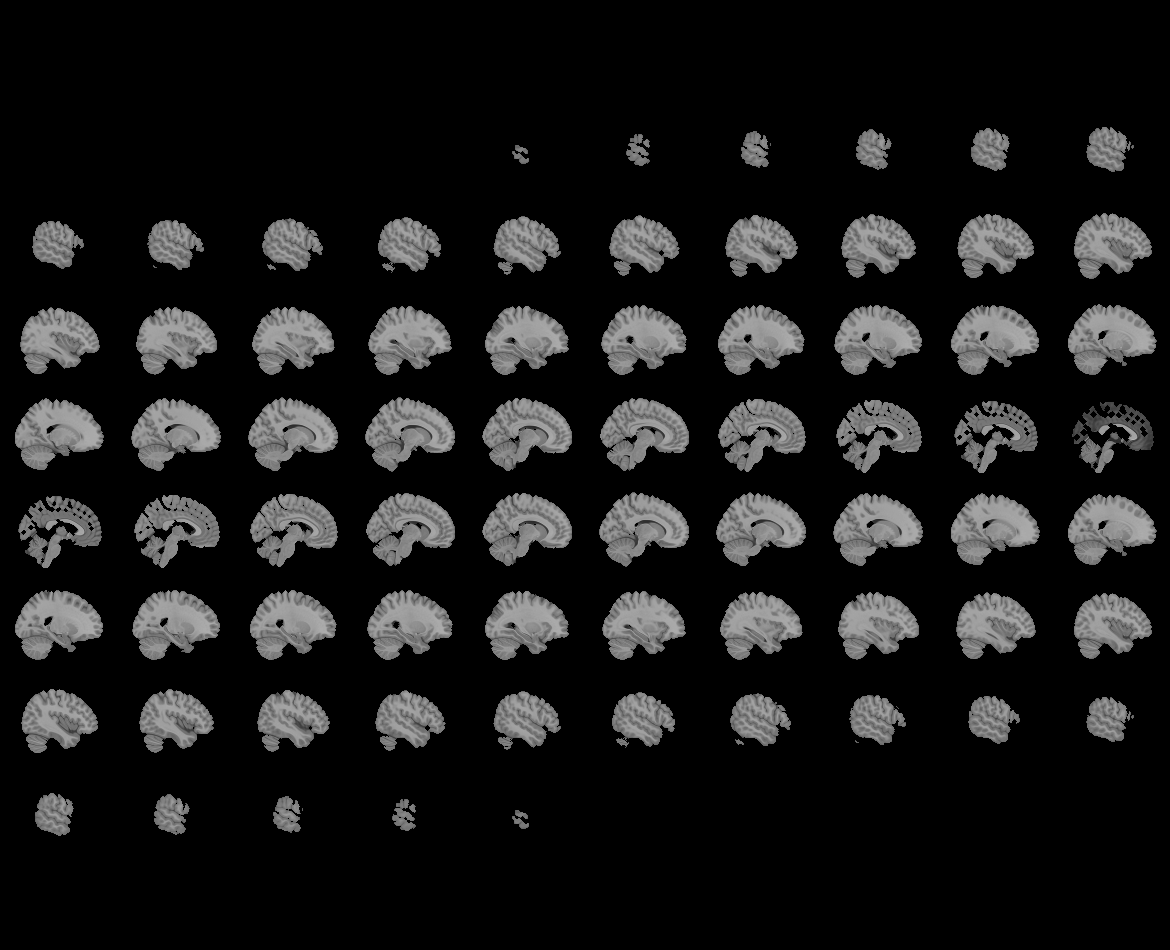
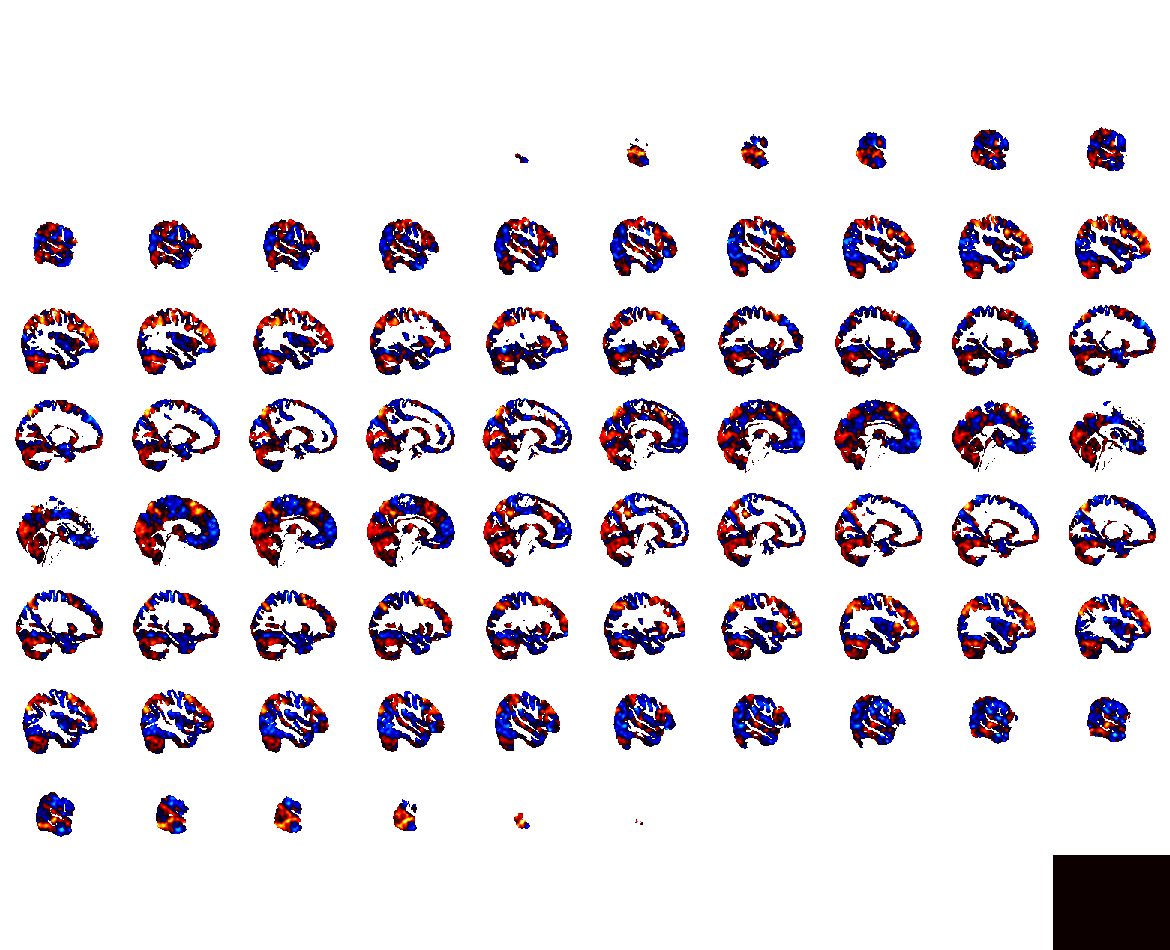

In [12]:
# Visualization of the nii image.
niifile = images[0]
condition = meta[0]['contrast_definition']

view = view_img(niifile,title=condition)
view

The whole fMRI scan is reduced to a signal spanning over 360 regions.



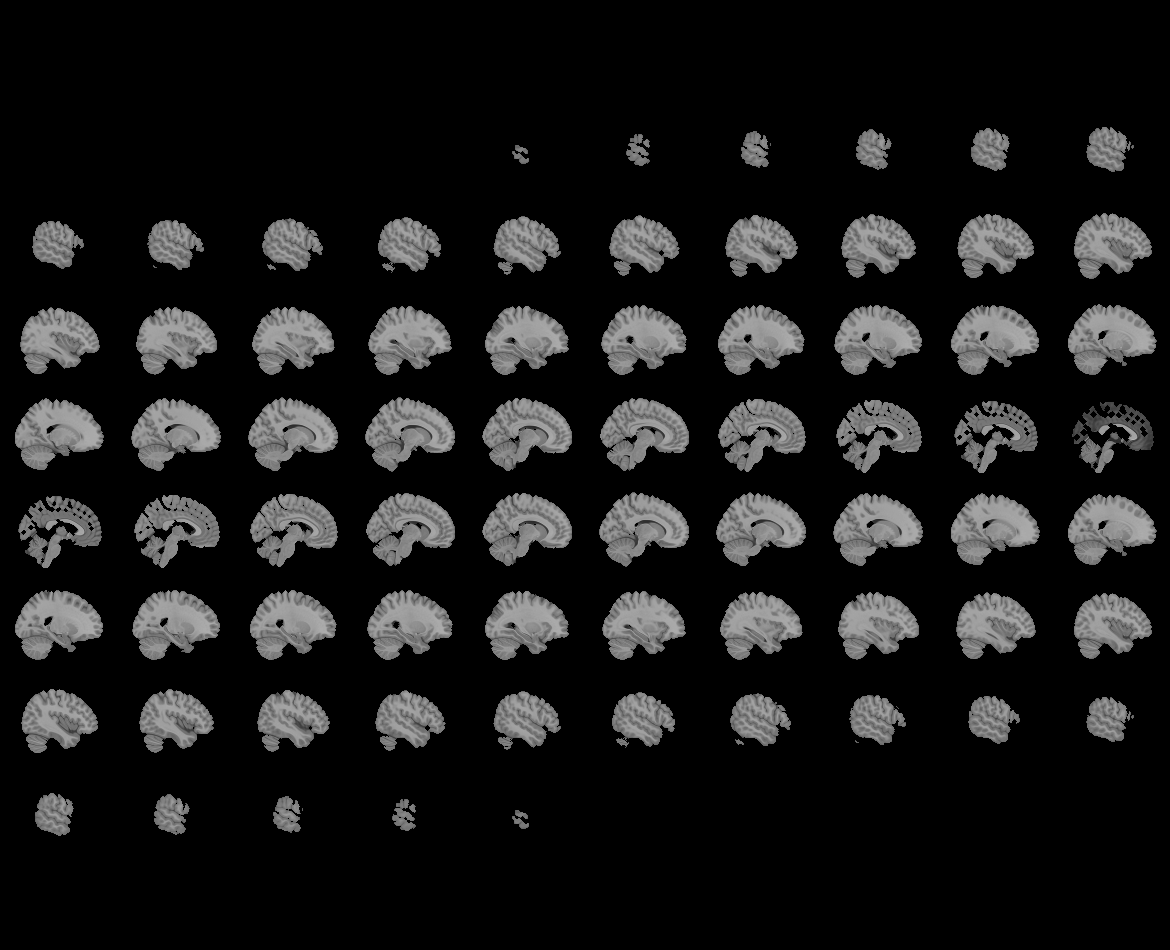
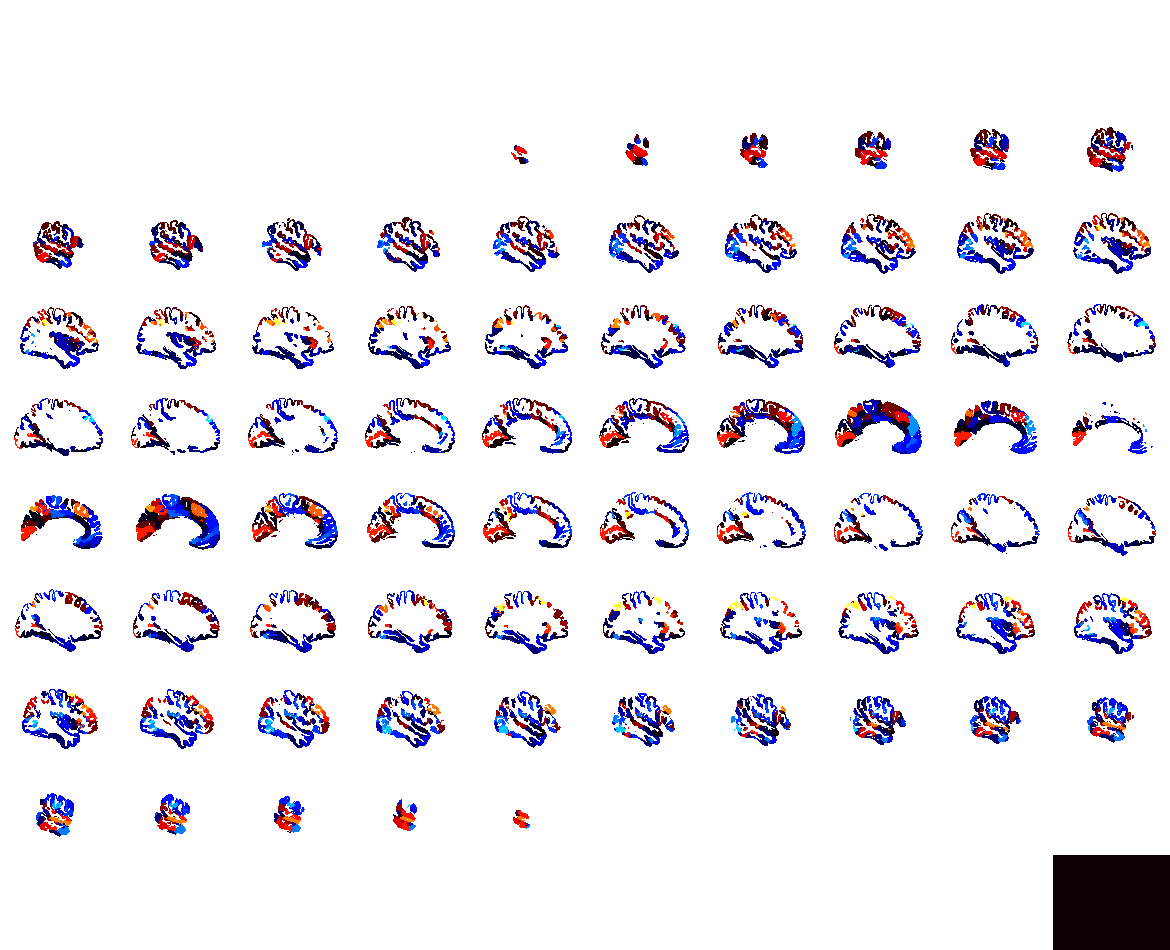

In [14]:
# Visualization of the parcellated image.
npzfile = os.path.splitext(os.path.splitext(niifile)[0])[0]+'.npz'
X = np.load(npzfile)['X']
print("The whole fMRI scan is reduced to a signal spanning over", X.shape[1], "regions.")
img = signals_to_img_labels(X,path_Glasser,mask_img=mask_mni)
view = view_img(img,title=condition)
view

/tmp/ipykernel_3187884/3871883707.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = roi.get_data()
/tmp/ipykernel_3187884/3871883707.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  indexes = np.unique(roi.get_data())



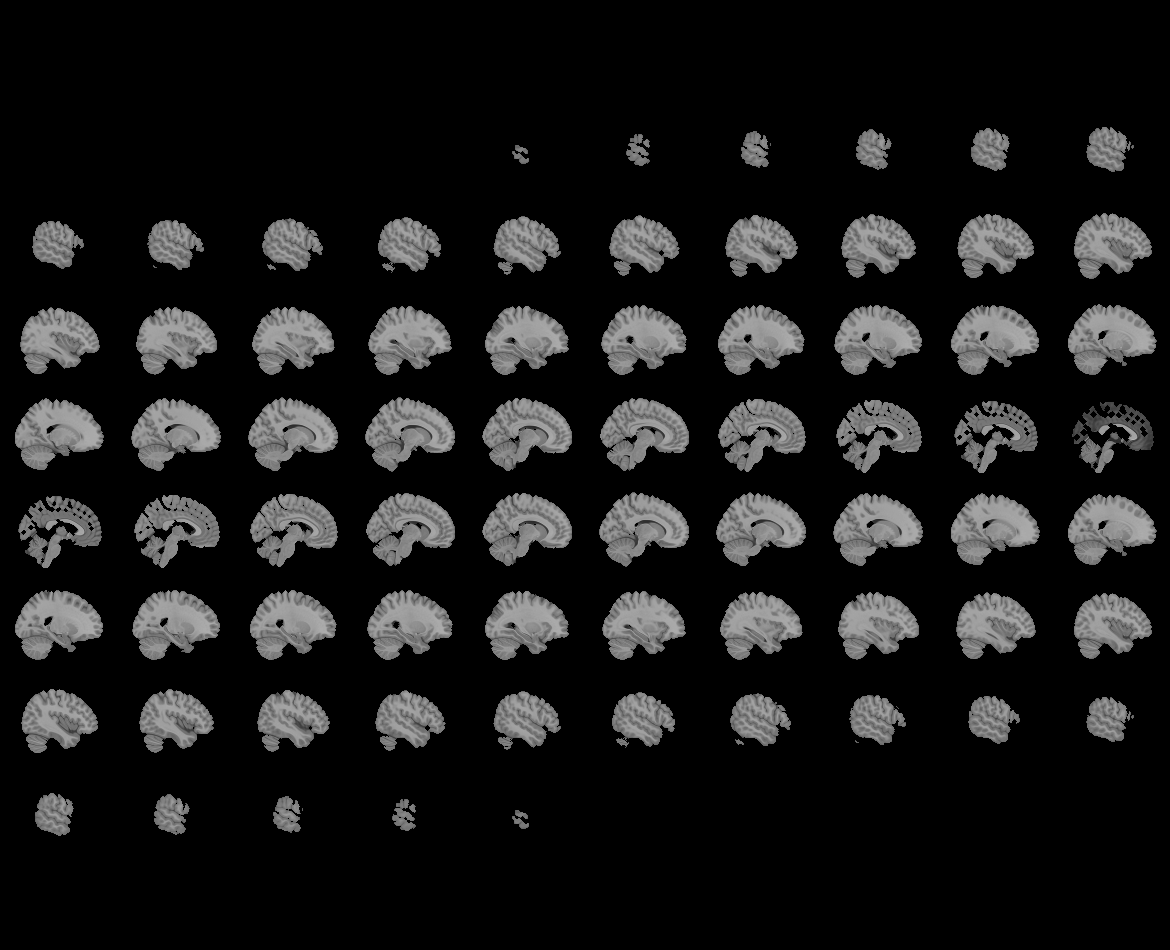
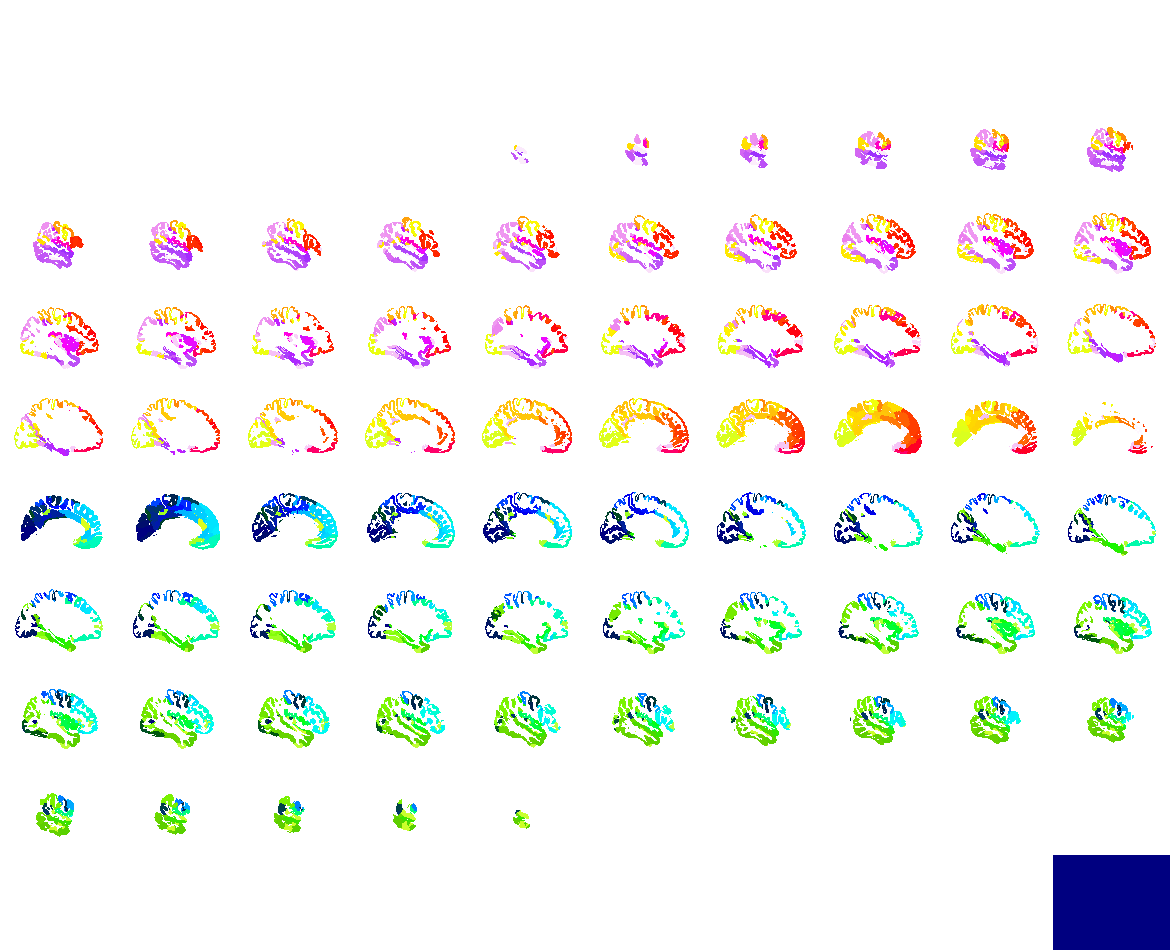

In [12]:
# Visualizing the ROI in a brain.

# Glasser contains 360 regions but their labels are floatting values between 0 and 54000.
# To better visualize the ROI, we can reindex the regions' labels. 

# First, we retrieve the data.
roi = load_img(path_Glasser)
data = roi.get_data()

# Then, we create a copy of the data in which, 
# we replace each label by its index in the sorted array of all labels.
indexes = np.unique(roi.get_data())

new_data = np.zeros(data.shape)
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        for z in range(data.shape[2]):
            value = data[x, y, z]
            index = np.where(indexes==value)[0]
            new_data[x, y, z] = index

# Finally, we save the reindexed version of Glasser and we plot it.
reindexed_roi = nib.Nifti1Image(new_data, roi.affine, roi.header)
nib.save(reindexed_roi, 'reindexed_roi.nii')
atlas = view_img('reindexed_roi.nii', vmax=360, symmetric_cmap=False, threshold=0.001, cmap='gist_ncar')
atlas

## New split

In [59]:
df_gby = df_6618.groupby('contrast_definition').agg({'subject_id':[set,'nunique']})['subject_id'].reset_index()

In [72]:
df_ = df_gby[df_gby['nunique']!=df_gby['nunique'].max()].reset_index()

In [106]:
set_subjects = df_.loc[0]['set']
for i in range(len(df_)-1):
    set_subjects = set_subjects.intersection(df_.loc[i+1]['set'])  

In [107]:
print('at least '+str(len(list(set_subjects)))+' common subjects per task')

at least 11 common subjects per task


In [111]:
np.random.seed(10)
id_train = list(np.random.choice(np.array(list(set(set_subjects))),8,replace=False))
id_val = [x for x in list(set_subjects) if x not in id_train]
id_test = [x for x in list(set(subjectnames)) if x not in id_train+id_val]

In [172]:
df = pd.DataFrame(list(zip(images, labels, tasks, meta,subjectnames)),columns=['Filename','Label','Task','Meta','Subject_id'])
df['Filename'] = df.Filename.apply(lambda x: x.split('/')[-1].split('.')[0])
df_train = df[df['Subject_id'].isin(id_train)]
df_val = df[df['Subject_id'].isin(id_val)]
df_test = df[df['Subject_id'].isin(id_test)]

print('The base set contains ', df_train.Label.nunique(), 'classes.')
print('The validation set contains ', df_val.Label.nunique(), 'classes.')
print('The test set contains ', df_test.Label.nunique(), 'classes.')
print('The base set contains ', len(df_train), 'data samples.')
print('The validation set contains ', len(df_val), 'data samples.')
print('The test set contains ', len(df_test), 'data samples.')

The base set contains  106 classes.
The validation set contains  106 classes.
The test set contains  67 classes.
The base set contains  2496 data samples.
The validation set contains  940 data samples.
The test set contains  412 data samples.


In [ ]:
if not os.path.exists('splits/split_IBC'):
    os.makedirs('splits/split_IBC')
df_train.to_csv('splits/split_IBC/'+'train.csv',index=False)
df_val.to_csv('splits/split_IBC/'+'val.csv',index=False)
df_test.to_csv('splits/split_IBC/'+'test.csv',index=False)

In [ ]:
# OLD SPLIT
# Split classes randomly.
# We only enforce that data samples computed from the same task are in the same set.
#all_tasks = np.unique(tasks)
#split = np.random.choice(all_tasks, replace=False, size=len(all_tasks))
#
## For instance, you can do...
#train_tasks = split[:15]
#val_tasks = split[15:20]
#test_tasks = split[20:]

# In our article, the first split we used is:
# train_tasks = ['emotional_pain', 'theory_of_mind', 'mtt_we', 'vstm', 'archi_standard', 'preference_food', 'preference_houses', 'self', 'hcp_wm', 'hcp_emotion', 'hcp_relational', 'hcp_language', 'hcp_motor', 'rsvp_language']
# val_tasks = ['archi_emotional', 'hcp_gambling', 'archi_social', 'preference_faces', 'pain_movie']
# test_tasks = ['preference_paintings', 'archi_spatial', 'mtt_sn', 'enumeration', 'hcp_social']

# The second split we used is:
# train_tasks = ['theory_of_mind', 'preference_faces', 'mtt_sn', 'enumeration', 'self', 'preference_food', 'mtt_we', 'vstm', 'emotional_pain', 'archi_standard', 'hcp_relational', 'pain_movie', 'hcp_motor', 'rsvp_language']
# val_tasks = ['preference_paintings', 'preference_houses', 'hcp_wm', 'archi_social']
# test_tasks = ['hcp_social', 'archi_spatial', 'hcp_language', 'hcp_emotion', 'archi_emotional', 'hcp_gambling']